In [1]:
import warnings
from argparse import ArgumentParser
from itertools import product
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.plot import heatmap
from graspy.utils import symmetrize
from joblib import Parallel, delayed
from scipy.stats import ttest_ind, wilcoxon, mannwhitneyu, multiscale_graphcorr, ks_2samp

from src import generate_truncnorm_sbms, compute_pr_at_k

warnings.filterwarnings("ignore")


/env/miniconda3/envs/dnd/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/env/miniconda3/envs/dnd/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/env/miniconda3/envs/dnd/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/env/miniconda3/envs/dnd/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/env/miniconda3/envs/dnd/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed

In [4]:
def compute_statistic(test, pop1, pop2):
    if test.__name__ == "ttest_ind":
        test_statistics, pvals = ttest_ind(pop1, pop2, axis=0)
        np.nan_to_num(test_statistics, copy=False)
        np.nan_to_num(pvals, copy=False)
    else:  # for other tests, do by edge
        n = pop1.shape[-1]
        test_statistics = np.zeros((n, n))
        pvals = np.zeros((n, n))

        for i in range(n):
            for j in range(i + 1, n):
                x_ij = pop1[:, i, j]
                y_ij = pop2[:, i, j]

                if test.__name__ == "multiscale_graphcorr":
                    tmp, pval, _ = test(x_ij, y_ij, is_twosamp=True, reps=1)
                else:
                    tmp, pval = test(x_ij, y_ij)

                test_statistics[i, j] = tmp
                pvals[i, j] = pval

        test_statistics = symmetrize(test_statistics, method="triu")
        pvals = symmetrize(pvals, method="triu")

    return test_statistics, pvals


def run_experiment(tests, m, block_1, block_2, mean_1, mean_2, var_1, var_2, ks, reps):
    precisions = []
    recalls = []

    for _ in range(reps):
        tmp_precisions = []
        tmp_recalls = []
        pop1, pop2, true_labels = generate_truncnorm_sbms(
            m=m,
            block_1=block_1,
            block_2=block_2,
            mean_1=mean_1,
            mean_2=mean_2,
            var_1=var_1,
            var_2=var_2,
        )

        for test in tests:
            test_statistics, pvalues = compute_statistic(test, pop1, pop2)
            if test.__name__ == "multiscale_graphcorr":
                precision, recall = compute_pr_at_k(
                    k=ks, true_labels=true_labels, test_statistics=test_statistics
                )
            else:
                precision, recall = compute_pr_at_k(
                    k=ks, true_labels=true_labels, pvalues=pvalues
                )
            tmp_precisions.append(precision)
            tmp_recalls.append(recall)

        precisions.append(tmp_precisions)
        recalls.append(tmp_recalls)

    precisions = np.array(precisions).mean(axis=0)
    recalls = np.array(recalls).mean(axis=0)

    to_append = [m, mean_1, mean_2, var_1, var_2, *precisions, *recalls]

    return to_append

In [5]:
tests = [ttest_ind, wilcoxon, mannwhitneyu, ks_2samp]

spacing = 50
block_1 = 5
block_2 = 15
mean_1 = 0
mean_2 = 0
var_1 = 1 / 2
var_2s = np.linspace(var_1, 3, spacing + 1)
ms = np.linspace(0, 500, spacing + 1).astype(int)[1:]
ks = range(5, 11)
reps = 100

args = [dict(m=m, var_2=var_2) for (m, var_2) in product(ms, var_2s)]

partial_func = partial(
    run_experiment,
    tests=tests,
    block_1=block_1,
    block_2=block_2,
    mean_1=mean_1,
    mean_2=mean_2,
    var_1=var_1,
    ks=ks,
    reps=reps,
)

res = Parallel(n_jobs=-1, verbose=1)(delayed(partial_func)(**arg) for arg in args)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done 1122 tasks      | elapsed: 81.8min
[Parallel(n_jobs=-1)]: Done 1672 tasks      | elapsed: 170.1min
[Parallel(n_jobs=-1)]: Done 2322 tasks      | elapsed: 315.3min
[Parallel(n_jobs=-1)]: Done 2550 out of 2550 | elapsed: 371.6min finished


In [6]:
new_res = []

for r in res:
    constants = r[:5]
    results = [b for a in r[5:] for b in a]
    new_res.append(constants + results)

In [7]:
cols = [
    "m",
    "mean1",
    "mean2",
    "var_1",
    "var_2",
    *[
        f"{test.__name__}_precision_at_{k}"
        for test in tests
        for k in ks
    ],
    *[
        f"{test.__name__}_recall_at_{k}"
        for test in tests
        for k in ks
    ],
]
res_df = pd.DataFrame(new_res, columns=cols)
res_df.to_csv(
    f"./results/20200223_changing_variances.csv", index=False
)

## Fig

In [5]:
res_df = pd.read_csv('./results/20200214_changing_variances.csv')

res_df.head()

,m,mean1,mean2,var_1,var_2,ttest_ind_precision_at_5,ttest_ind_precision_at_6,ttest_ind_precision_at_7,ttest_ind_precision_at_8,ttest_ind_precision_at_9,...,multiscale_graphcorr_precision_at_7,multiscale_graphcorr_precision_at_8,multiscale_graphcorr_precision_at_9,multiscale_graphcorr_precision_at_10,multiscale_graphcorr_recall_at_5,multiscale_graphcorr_recall_at_6,multiscale_graphcorr_recall_at_7,multiscale_graphcorr_recall_at_8,multiscale_graphcorr_recall_at_9,multiscale_graphcorr_recall_at_10
0,10,0,0,0.5,0.50,0.044,0.046667,0.045714,0.04500,0.043333,...,0.061429,0.06125,0.058889,0.057,0.031,0.034,0.043,0.049,0.053,0.057
1,10,0,0,0.5,0.55,0.054,0.053333,0.055714,0.05375,0.056667,...,0.047143,0.04750,0.044444,0.045,0.020,0.027,0.033,0.038,0.040,0.045
2,10,0,0,0.5,0.60,0.044,0.045000,0.048571,0.05500,0.050000,...,0.067143,0.06125,0.060000,0.063,0.037,0.041,0.047,0.049,0.054,0.063
3,10,0,0,0.5,0.65,0.038,0.038333,0.042857,0.03875,0.038889,...,0.062857,0.06000,0.054444,0.057,0.030,0.040,0.044,0.048,0.049,0.057
4,10,0,0,0.5,0.70,0.056,0.055000,0.054286,0.06125,0.056667,...,0.061429,0.06125,0.061111,0.059,0.030,0.035,0.043,0.049,0.055,0.059


KeyError: 'ks_2samp'

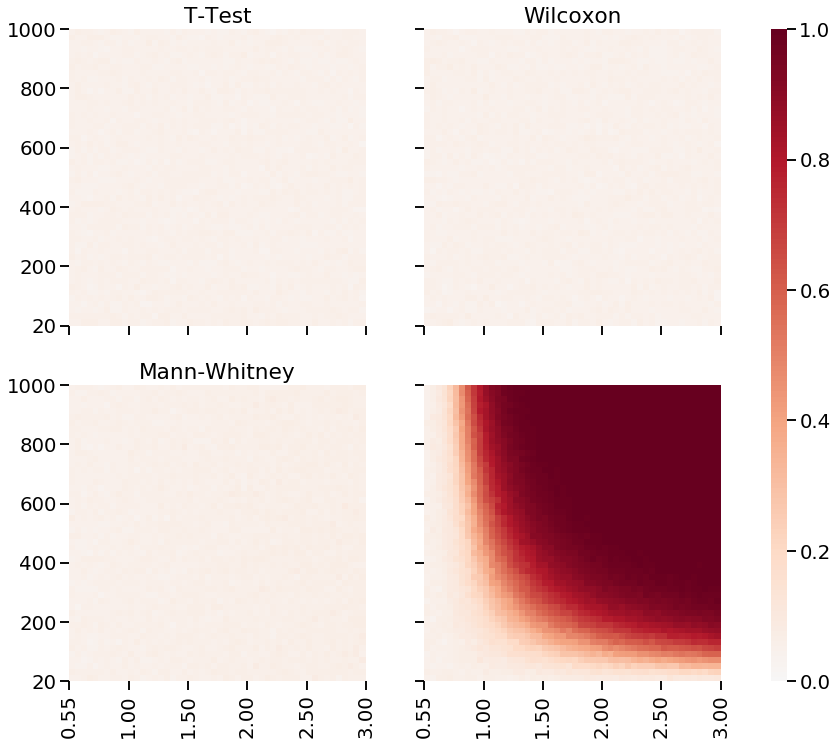

In [9]:
# Make figure with correct subplots
sns.set_context('talk', font_scale=1.2)
fig, ax = plt.subplots(
    2, 3, gridspec_kw={"width_ratios": [1, 1, 0.05]},
    figsize=(13, 12),
    sharex=True,
    sharey=True
)
gs = ax[-1, -1].get_gridspec()
for ax_ in ax[:, -1]:
    ax_.remove()

ax_leg = fig.add_subplot(gs[:, -1])

# Plotting
res_df = res_df[res_df.var_2 != 0.5]

tests = [[ttest_ind, wilcoxon], [mannwhitneyu, ks_2samp]]
names = dict(
    ttest_ind = "T-Test",
    wilcoxon = "Wilcoxon",
    mannwhitneyu = "Mann-Whitney",
    multiscale_graphcorr = "MGC",
    ks_2samp = "Kolmogrov-Smirnov"
)

fmt = lambda x: "{:.2f}".format(x)

p = 0.5
spacing = 50
deltas = np.linspace(.5, 3, spacing + 1)[::10]
deltas[0] += 0.05
ms = np.linspace(0, 500, spacing + 1)[::10] * 2
ms[0] += 20


for i, row in enumerate(tests):
    for j, test in enumerate(row):
        sns.heatmap(
            np.flipud(res_df[f"{test.__name__}_precision_at_10"].values.reshape(spacing, -1)),
            ax=ax[i, j],
            square=True,
            center=0,
            cmap="RdBu_r",
            cbar_kws=dict(shrink=0.7),
            xticklabels=[fmt(d) for d in deltas],
            yticklabels=["{:.0f}".format(m) for m in ms],
            cbar_ax=ax_leg,
            vmin=0,
            vmax=1,
        )
        ax[i, j].set_xticks(np.arange(0, ax[0, 0].get_xlim()[1] + 1, 10))
        ax[i, j].set_yticks(np.arange(0, ax[0, 0].get_ylim()[0] + 1, 10)[::-1])
        #if i != 0:
        #    ax[i, j].yaxis.set_major_formatter(plt.NullFormatter())
        ax[i, j].set_title(f"{names[test.__name__]}")

fig.text(0.5, .95, "Precision@10", va='center', ha='center')
fig.text(0.025, 0.5, "Sample Size", va="center", rotation="vertical")
fig.text(0.5, 0.02, "Variance", va="center", ha="center")

In [28]:
fig.savefig("./figures/20200214_changing_variances.png", dpi=300, bbox_inches='tight')